In [22]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

img_dir = 'train'
mask_dir = 'train/masks'
excel_file = 'train/classif.xlsx'
data_feature_file = 'data_features.csv'

# Load classification file
def load_classification(excel_file):
    if os.path.exists(excel_file):
        return pd.read_excel(excel_file)
    else:
        print(f"Excel file {excel_file} not found.")
        return None

# Load features
def load_features(data_feature_file):
    if os.path.exists(data_feature_file):
        return pd.read_csv(data_feature_file)
    else:
        print(f"Feature file {data_feature_file} not found.")
        return None

classif_df = load_classification(excel_file)
features_df = load_features(data_feature_file)

# 处理标签
def process_labels(df):
    bug_types = []
    species = []
    
    for _, row in df.iterrows():
        bugs = row['bug_type']
        species_info = row['species']
        
        # 处理x2
        if ' x2' in species_info:
            bugs = [bugs.replace(' x2','')] * 2
            species_info = [species_info.replace(' x2','')] * 2
        else:
            bugs = bugs.split(' & ')
            species_info = species_info.split(' & ')
        
        # 处理问号
        bugs = [bug.replace(' ?', '') for bug in bugs]
        species_info = [specie.replace(' ?', '') for specie in species_info]
        
        bug_types.append(bugs)
        species.append(species_info)
    
    df['bug_type'] = bug_types
    df['species'] = species
    return df

classif_df = process_labels(classif_df)
print(classif_df.head())

# 使用MultiLabelBinarizer转换标签
mlb_bug_type = MultiLabelBinarizer()
mlb_species = MultiLabelBinarizer()

bug_type_encoded = mlb_bug_type.fit_transform(classif_df['bug_type'])
species_encoded = mlb_species.fit_transform(classif_df['species'])

# 转换为DataFrame
bug_type_df = pd.DataFrame(bug_type_encoded, columns=mlb_bug_type.classes_)
species_df = pd.DataFrame(species_encoded, columns=mlb_species.classes_)

# 合并所有数据
all_data_df = pd.concat([classif_df.drop(columns=['bug_type', 'species']), bug_type_df, species_df, features_df], axis=1)


   ID bug_type           species
0   1    [Bee]  [Apis mellifera]
1   2    [Bee]  [Apis mellifera]
2   3    [Bee]  [Apis mellifera]
3   4    [Bee]  [Apis mellifera]
4   5    [Bee]  [Apis mellifera]


/var/folders/vz/pml3623s7tgb51yxff04lsl00000gn/T/ipykernel_35181/318696258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values,  palette="viridis")


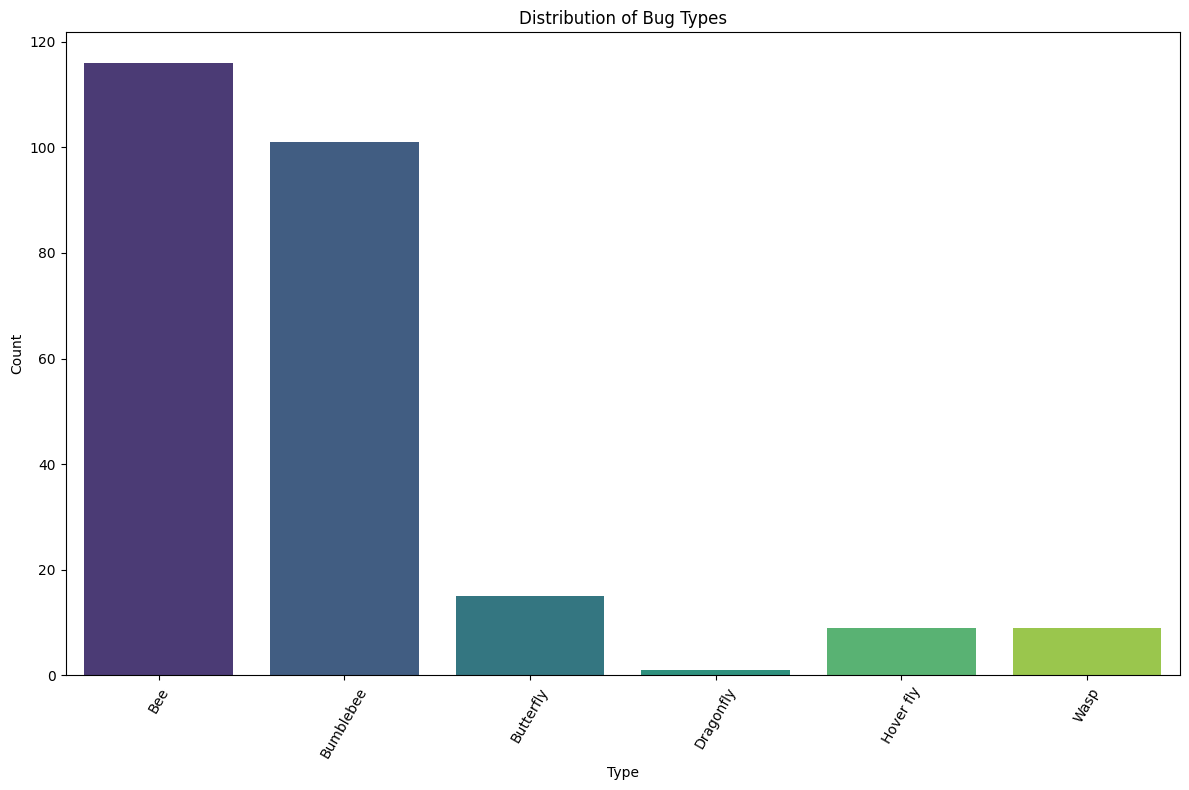

/var/folders/vz/pml3623s7tgb51yxff04lsl00000gn/T/ipykernel_35181/318696258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values,  palette="viridis")


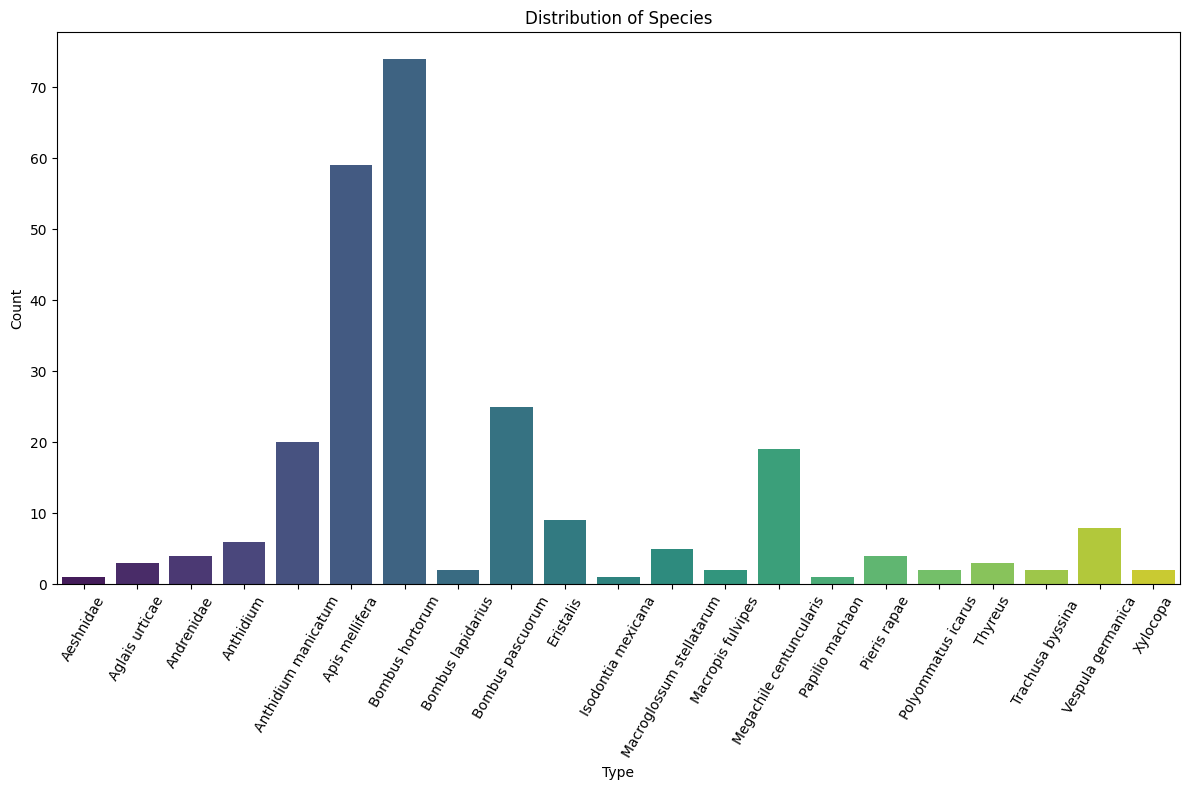

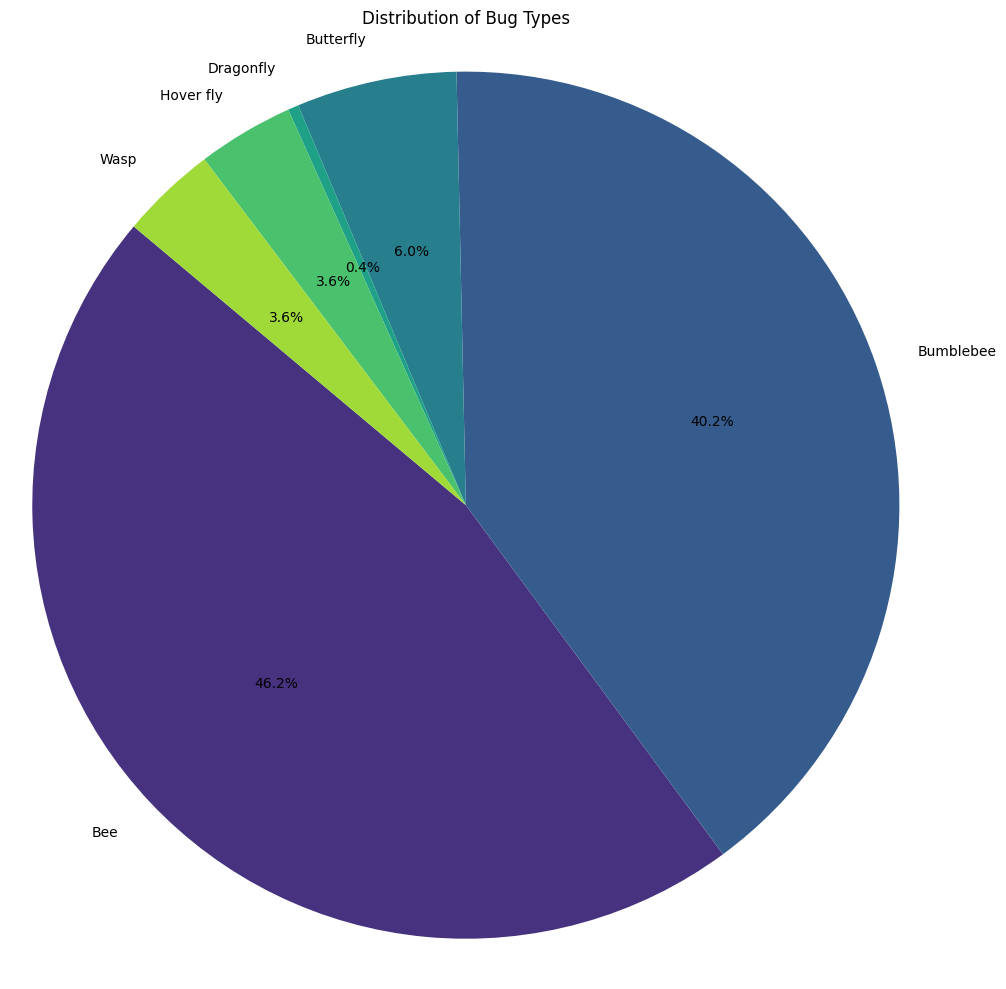

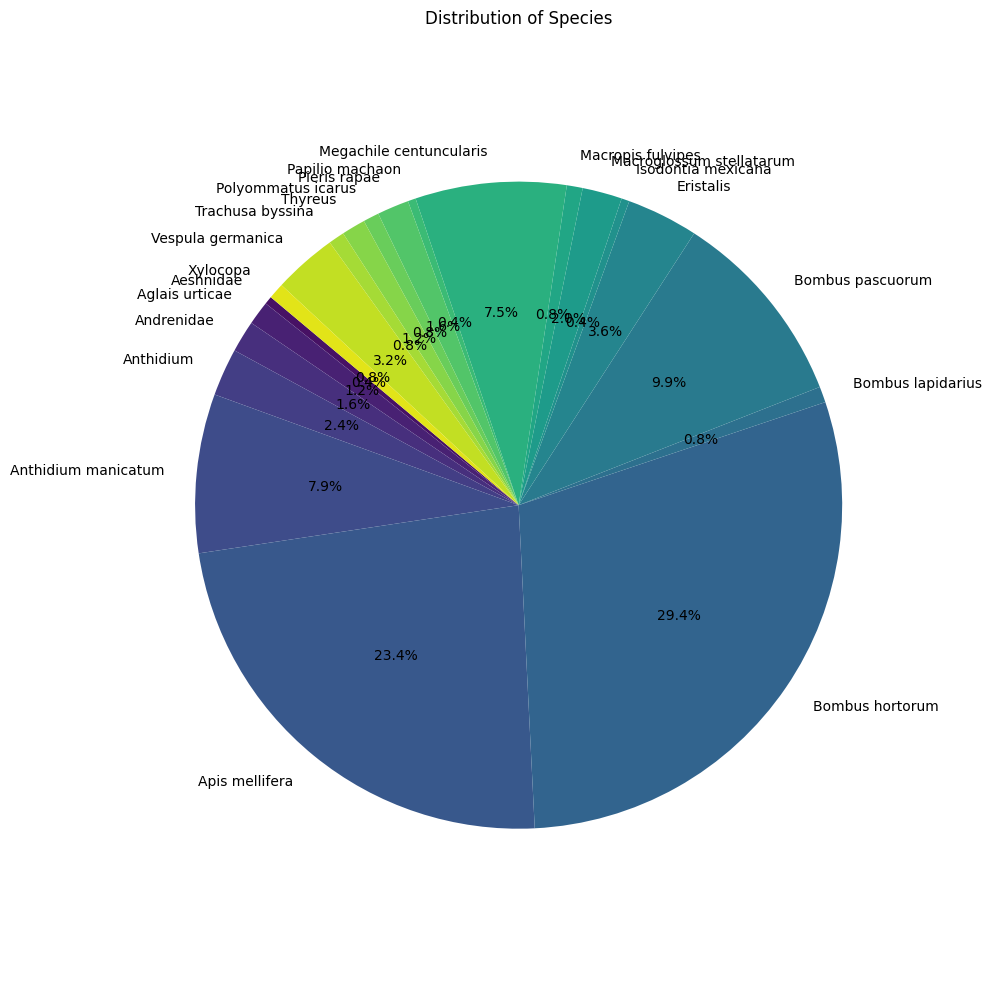

In [23]:
# 可视化分布
def plot_distribution(data, title):
    counts = data.sum()
    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts.index, y=counts.values,  palette="viridis")
    plt.title(title)
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_distribution(bug_type_df, 'Distribution of Bug Types')
plot_distribution(species_df, 'Distribution of Species')

# 昆虫类型分布的饼图
def plot_pie_distribution(data, title):
    counts = data.sum()
    colors = sns.color_palette('viridis', len(counts))
    plt.figure(figsize=(10, 10))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140,colors=colors)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout() 
    plt.show()

plot_pie_distribution(bug_type_df, 'Distribution of Bug Types')
plot_pie_distribution(species_df, 'Distribution of Species')


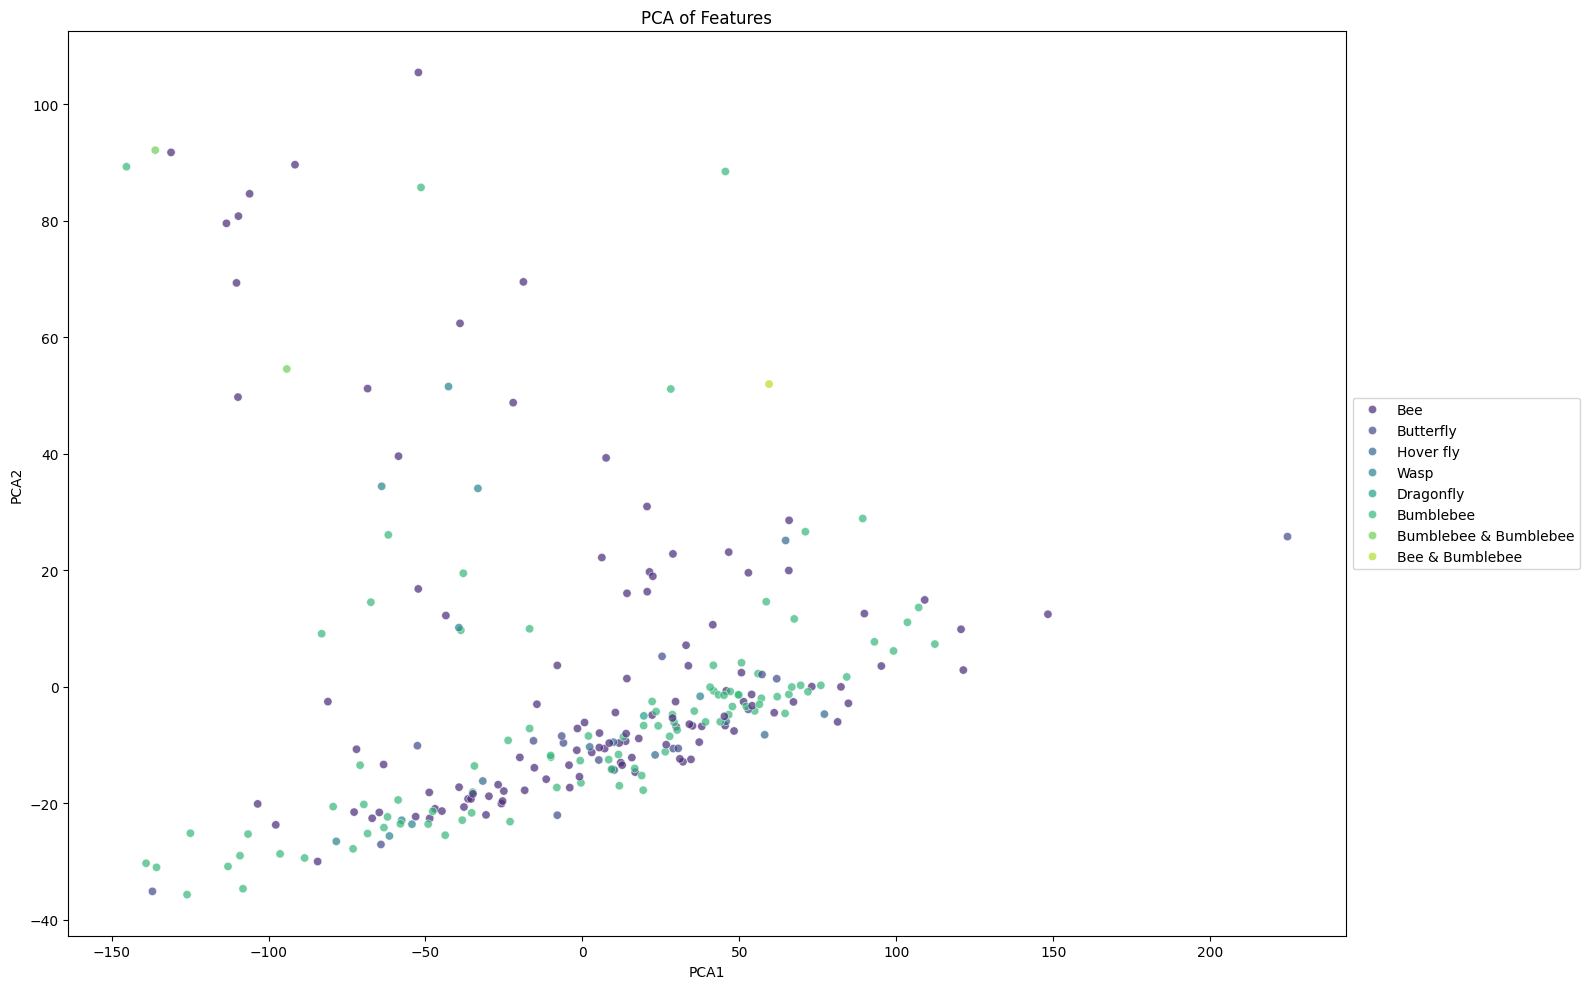

In [25]:
# 提取特征数据
features = features_df  # 假设features_df包含所有特征数据

# 执行PCA降维到2维
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# 创建PCA结果的DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['bug_type'] = classif_df['bug_type'].apply(lambda x: ' & '.join(x))  # 将多标签连接为字符串

# 可视化PCA结果
plt.figure(figsize=(16, 10), dpi=100)
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='bug_type',
    palette=sns.color_palette('viridis', len(pca_df['bug_type'].unique())),
    data=pca_df,
    legend="full",
    alpha=0.7
)
plt.title('PCA of Features')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.tight_layout()
plt.show()


In [32]:
from sklearn.manifold import TSNE
import umap

# t-SNE 投影到2维
def plot_tsne_projection(features_df, classif_df):
    features = features_df.select_dtypes(include=[np.number])  # 只选择数值型特征
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features)
    
    # 创建t-SNE结果的DataFrame
    tsne_df = pd.DataFrame(data=tsne_result, columns=['tSNE1', 'tSNE2'])
    tsne_df = pd.concat([tsne_df, classif_df[['bug_type']]], axis=1)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='tSNE1', y='tSNE2', hue='bug_type', data=tsne_df, palette='viridis')
    plt.title('t-SNE Projection of Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Bug Type', loc='best')
    plt.show()

plot_tsne_projection(features_df, classif_df)

# UMAP 投影到2维
def plot_umap_projection(features_df, classif_df):
    features = features_df.select_dtypes(include=[np.number])  # 只选择数值型特征
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    umap_result = umap_reducer.fit_transform(features)
    
    # 创建UMAP结果的DataFrame
    umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
    umap_df = pd.concat([umap_df, classif_df[['bug_type']]], axis=1)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='bug_type', data=umap_df, palette='viridis')
    plt.title('UMAP Projection of Features')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend(title='Bug Type', loc='best')
    plt.show()

plot_umap_projection(features_df, classif_df)



TypeError: unhashable type: 'list'

<Figure size 1000x700 with 0 Axes>

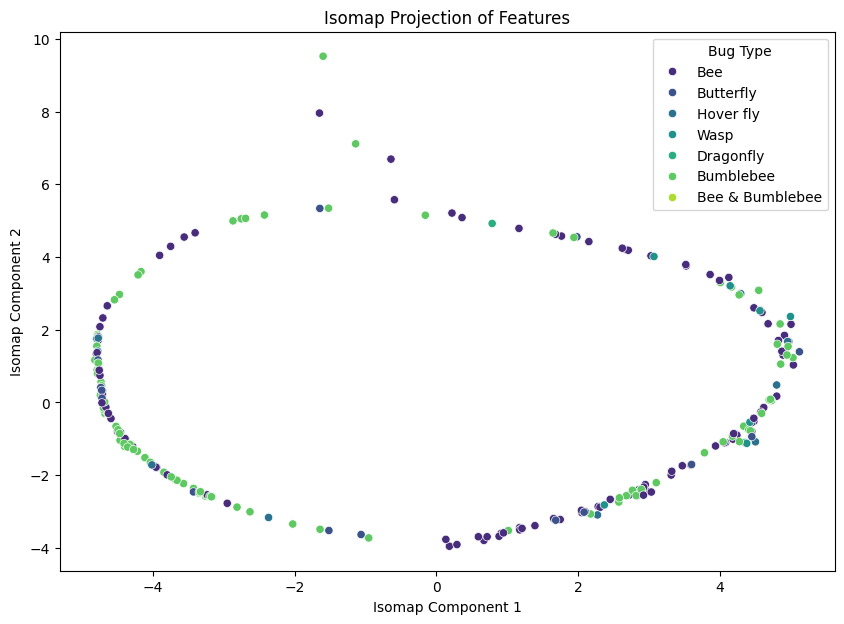

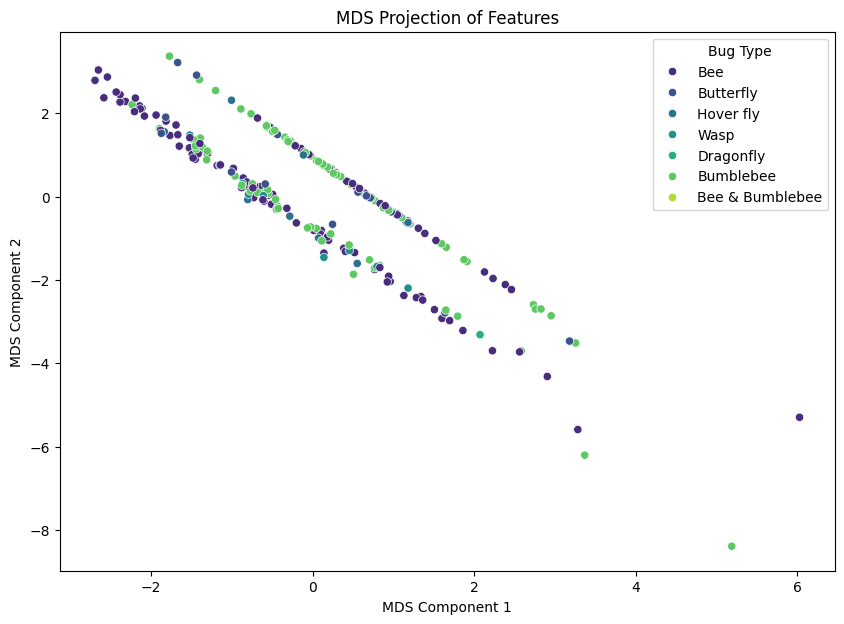

In [6]:
from sklearn.manifold import Isomap, MDS

def plot_isomap_projection(features_df, classif_df):
    features = features_df.select_dtypes(include=[np.number])  # 只选择数值型特征
    isomap = Isomap(n_components=2)
    isomap_result = isomap.fit_transform(features)
    
    # 创建Isomap结果的DataFrame
    isomap_df = pd.DataFrame(data=isomap_result, columns=['ISOMAP1', 'ISOMAP2'])
    isomap_df = pd.concat([isomap_df, classif_df[['bug_type']]], axis=1)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='ISOMAP1', y='ISOMAP2', hue='bug_type', data=isomap_df, palette='viridis')
    plt.title('Isomap Projection of Features')
    plt.xlabel('Isomap Component 1')
    plt.ylabel('Isomap Component 2')
    plt.legend(title='Bug_Type', loc='best')
    plt.show()

# 使用MDS进行特征降维
def plot_mds_projection(features_df, classif_df):
    features = features_df.select_dtypes(include=[np.number])  # 只选择数值型特征
    mds = MDS(n_components=2, random_state=42)
    mds_result = mds.fit_transform(features)
    
    # 创建MDS结果的DataFrame
    mds_df = pd.DataFrame(data=mds_result, columns=['MDS1', 'MDS2'])
    mds_df = pd.concat([mds_df, classif_df[['bug_type']]], axis=1)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='MDS1', y='MDS2', hue='bug_type', data=mds_df, palette='viridis')
    plt.title('MDS Projection of Features')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.legend(title='Bug_Type', loc='best')
    plt.show()

# 调用函数进行Isomap投影可视化
plot_isomap_projection(features_df, classif_df)

# 调用函数进行MDS投影可视化
plot_mds_projection(features_df, classif_df)